## Medical Diagnostics - Nodule/Normal lung classification with Convolutional Neural Networks

The folder Data contains the following folders:
* train
* test
* val
</a>
Each of these folders contains a 'nodule' and a 'normal' folder.

The images are downloaded by running the foloowing scripts<br>
A1_getRawImages.py downloads over 7000 images from NIH.  Also The file ./pythoncode/data_new.json describes what each of these images show.<br>
A2_processRawImages.py  seperate and balance datasets into the above train/test/val folders

In [43]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#add this to get to the fastai libraries
import sys
sys.path.insert(0, '..')


In [44]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [45]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

**PATH** is the path to your data - <br>
**sz** is the size that the images will be resized to in order to ensure that the training runs quickly. Leave it at 224 for now.<br>
**arch** the pretrained architecture to use<br>
**bs**  batch size

In [46]:
PATH = "data/"
sz=224
arch=resnext50
bs =2

In [47]:
#make sure cuda available 
print("Is cuda available? " + str(torch.cuda.is_available()))

#and cudnn?
print("Is cudnn enabled? " + str(torch.backends.cudnn.enabled))

Is cuda available? True
Is cudnn enabled? True


## The model

In [48]:
# Uncomment the below if you need to reset your precomputed activations
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [64]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 200)

epoch      trn_loss   val_loss   accuracy        
    0      0.978901   0.937326   0.032258  
    1      0.803923   1.237534   0.193548        
    2      0.70497    1.317199   0.290323        
    3      0.588526   1.233387   0.419355        
    4      0.510027   1.293468   0.322581        
    5      0.458065   1.321736   0.322581        
    6      0.402763   1.338071   0.483871        
    7      0.357886   1.576989   0.387097        
    8      0.315751   1.806998   0.322581        
    9      0.281175   1.856556   0.387097        
    10     0.254666   2.010634   0.419355        
    11     0.231527   2.158884   0.419355        
    12     0.209453   2.412274   0.419355        
    13     0.189243   2.554279   0.419355        
    14     0.172983   2.511228   0.419355        
    15     0.157551   2.562266   0.419355        
    16     0.147857   2.39401    0.451613        
    17     0.135434   2.372761   0.451613        
    18     0.124195   2.461737   0.419355        
    19

   158     0.005728   4.447013   0.354839          
   159     0.005305   4.308227   0.387097          
   160     0.005124   4.33253    0.354839          
   161     0.005339   4.365552   0.419355          
   162     0.004966   4.284558   0.419355          
   163     0.007196   4.054331   0.451613          
   164     0.006624   4.12579    0.387097          
   165     0.00661    4.182635   0.387097          
   166     0.008509   3.9423     0.419355          
   167     0.00843    4.020026   0.483871          
   168     0.007959   3.934254   0.516129          
   169     0.007754   3.953449   0.516129          
   170     0.008103   4.007872   0.516129          
   171     0.007953   4.124884   0.483871          
   172     0.007669   4.184503   0.451613          
   173     0.008197   4.225116   0.387097          
   174     0.007746   4.111966   0.387097          
   175     0.007463   4.136755   0.387097          
   176     0.006874   4.177658   0.387097          
   177     0

[4.539055347442627, 0.4838709533214569]

How good is this model? Well, as we mentioned, prior to this competition, the state of the art was 80% accuracy. But the competition resulted in a huge jump to 98.9% accuracy, with the author of a popular deep learning library winning the competition. Extraordinarily, less than 4 years later, we can now beat that result in seconds! Even last year in this same course, our initial model had 98.3% accuracy, which is nearly double the error we're getting just a year later, and that took around 10 minutes to compute.

## Analyzing results: looking at pictures

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (i.e. those with highest probability that are correct)
4. The most incorrect labels of each class (i.e. those with highest probability that are incorrect)
5. The most uncertain labels (i.e. those with probability closest to 0.5).

In [50]:
# This is the label for a val data
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [51]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

['nodule', 'normal']

In [52]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(31, 2)

In [53]:
log_preds[:10]

array([[-1.20604, -0.35579],
       [-0.80353, -0.59374],
       [-0.96324, -0.48071],
       [-2.59004, -0.07798],
       [-1.33906, -0.30394],
       [-1.51634, -0.24784],
       [-3.33361, -0.03632],
       [-1.43077, -0.27329],
       [-2.01476, -0.14312],
       [-2.12532, -0.12715]], dtype=float32)

In [54]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [55]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [56]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [57]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [58]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [59]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

ValueError: Cannot take a larger sample than population when 'replace=False'

Incorrectly classified


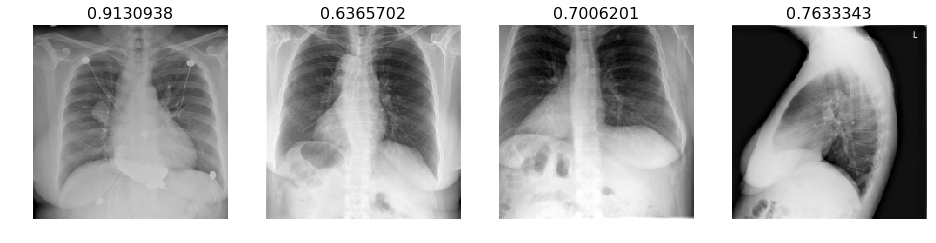

In [60]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [61]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct nodule


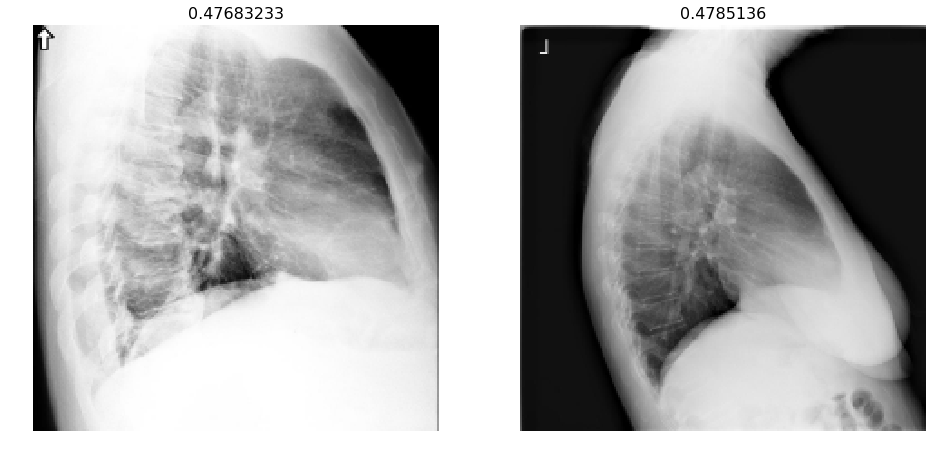

In [62]:
plot_val_with_title(most_by_correct(0, True), "Most correct nodule")

Most correct normal


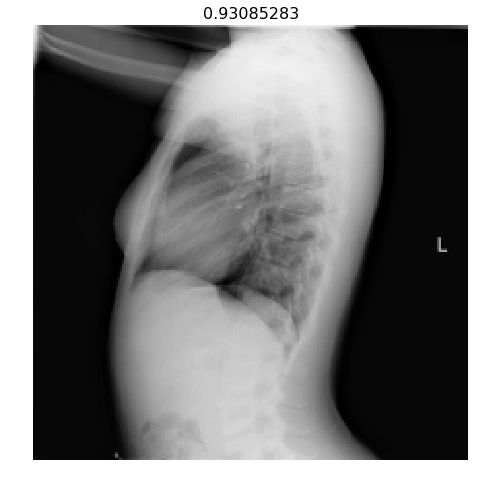

In [21]:
plot_val_with_title(most_by_correct(1, True), "Most correct normal")

Most incorrect nodule


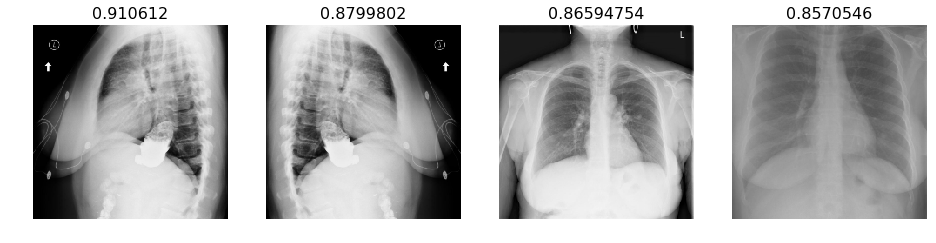

In [22]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect nodule")

In [23]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect normal")

Most incorrect normal


<Figure size 1152x576 with 0 Axes>

Most uncertain predictions


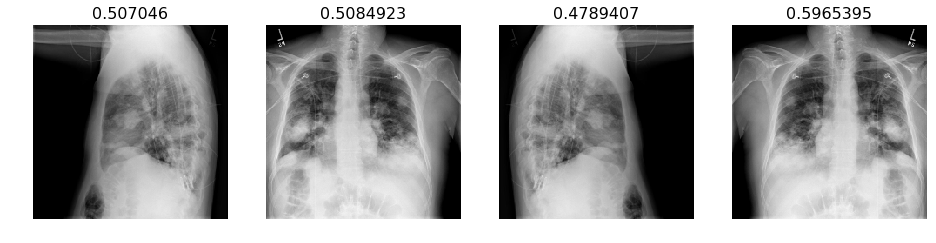

In [24]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Choosing a learning rate

The *learning rate* determines how quickly or how slowly you want to update the *weights* (or *parameters*). Learning rate is one of the most difficult parameters to set, because it significantly affects model performance.

The method `learn.lr_find()` helps you find an optimal learning rate. It uses the technique developed in the 2015 paper [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186), where we simply keep increasing the learning rate from a very small value, until the loss stops decreasing. We can plot the learning rate across batches to see what this looks like.

We first create a new learner, since we want to know how to set the learning rate for a new (untrained) model.

In [65]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [66]:
lrf=learn.lr_find()

epoch      trn_loss   val_loss   accuracy        
    0      0.987187   0.580877   0.806452  


Our `learn` object contains an attribute `sched` that contains our learning rate scheduler, and has some convenient plotting functionality including this one:

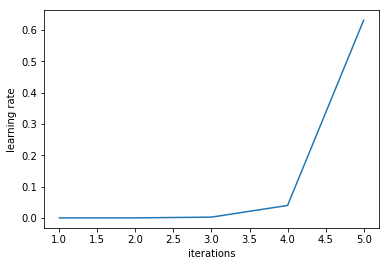

In [67]:
learn.sched.plot_lr()

Note that in the previous plot *iteration* is one iteration (or *minibatch*) of SGD. In one epoch there are 
(num_train_samples/num_iterations) of SGD.

We can see the plot of loss versus learning rate to see where our loss stops decreasing:

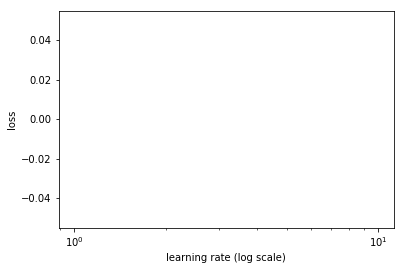

In [68]:
learn.sched.plot()

The loss is still clearly improving at lr=1e-1 (0.1), so that's what we use. Note that the optimal learning rate can change as we training the model, so you may want to re-run this function from time to time.

## Improving our model

### Data augmentation

If you try training for more epochs, you'll notice that we start to *overfit*, which means that our model is learning to recognize the specific images in the training set, rather than generalizing such that we also get good results on the validation set. One way to fix this is to effectively create more data, through *data augmentation*. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.

We can do this by passing `aug_tfms` (*augmentation transforms*) to `tfms_from_model`, with a list of functions to apply that randomly change the image however we wish. For photos that are largely taken from the side (e.g. most photos of dogs and cats, as opposed to photos taken from the top down, such as satellite imagery) we can use the pre-defined list of functions `transforms_side_on`. We can also specify random zooming of images up to specified scale by adding the `max_zoom` parameter.

In [29]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [30]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [31]:
ims = np.stack([get_augs() for i in range(6)])

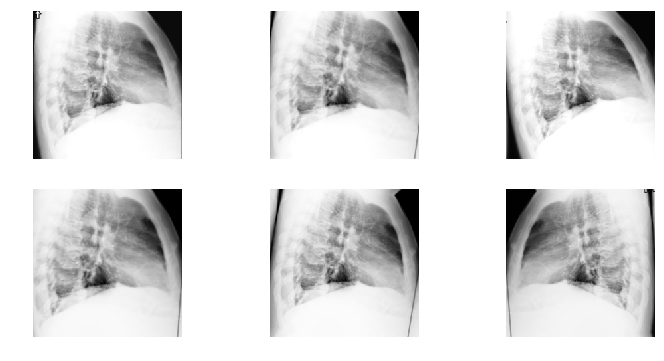

In [32]:
plots(ims, rows=2)

Let's create a new `data` object that includes this augmentation in the transforms.

In [33]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [34]:
learn.fit(1e-1, 10)

epoch      trn_loss   val_loss   accuracy        
    0      0.86531    2.877558   0.032258  
    1      0.993829   1.832935   0.258065        
    2      0.798555   1.682268   0.516129        
    3      0.699753   5.663968   0.258065        
    4      0.614686   4.826198   0.258065        
    5      0.521431   3.115304   0.580645        
    6      0.47399    4.420767   0.516129        
    7      0.440677   7.159715   0.322581        
    8      0.408278   6.382022   0.419355        
    9      0.389777   6.790095   0.451613        



[6.79009485244751, 0.4516128897666931]

In [35]:
learn.precompute=False

By default when we create a learner, it sets all but the last layer to *frozen*. That means that it's still only updating the weights in the last layer when we call `fit`.

In [ ]:
learn.fit(1e-1, 10, cycle_len=2)

What is that `cycle_len` parameter? What we've done here is used a technique called *stochastic gradient descent with restarts (SGDR)*, a variant of *learning rate annealing*, which gradually decreases the learning rate as training progresses. This is helpful because as we get closer to the optimal weights, we want to take smaller steps.

However, we may find ourselves in a part of the weight space that isn't very resilient - that is, small changes to the weights may result in big changes to the loss. We want to encourage our model to find parts of the weight space that are both accurate and stable. Therefore, from time to time we increase the learning rate (this is the 'restarts' in 'SGDR'), which will force the model to jump to a different part of the weight space if the current area is "spikey". Here's a picture of how that might look if we reset the learning rates 3 times (in this paper they call it a "cyclic LR schedule"):

<img src="images/sgdr.png" width="80%">
(From the paper [Snapshot Ensembles](https://arxiv.org/abs/1704.00109)).

The number of epochs between resetting the learning rate is set by `cycle_len`, and the number of times this happens is refered to as the *number of cycles*, and is what we're actually passing as the 2nd parameter to `fit()`. So here's what our actual learning rates looked like:

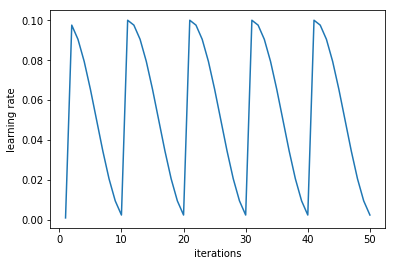

In [37]:
learn.sched.plot_lr()

Our validation loss isn't improving much, so there's probably no point further training the last layer on its own.

Since we've got a pretty good model at this point, we might want to save it so we can load it again later without training it from scratch.

In [38]:
learn.save('224_lastlayer')

In [39]:
learn.load('224_lastlayer')

### Fine-tuning and differential learning rate annealing

Now that we have a good final layer trained, we can try fine-tuning the other layers. To tell the learner that we want to unfreeze the remaining layers, just call (surprise surprise!) `unfreeze()`.

In [40]:
learn.unfreeze()

Note that the other layers have *already* been trained to recognize imagenet photos (whereas our final layers where randomly initialized), so we want to be careful of not destroying the carefully tuned weights that are already there.

Generally speaking, the earlier layers (as we've seen) have more general-purpose features. Therefore we would expect them to need less fine-tuning for new datasets. For this reason we will use different learning rates for different layers: the first few layers will be at 1e-4, the middle layers at 1e-3, and our FC layers we'll leave at 1e-2 as before. We refer to this as *differential learning rates*, although there's no standard name for this techique in the literature that we're aware of.

In [41]:
lr=np.array([1e-2,3e-2,1e-1])   #the images are vastly different from imagenet, so higher learning rates

In [42]:
learn.fit(lr, 6, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy               
    0      6.34094    3135.99707 0.967742  
    1      4.424147   90637.828125 0.967742             
    2      3.638448   67.32943   0.967742               
    3      3.078422   1864.482178 0.032258              
    4      2.675073   0.453591   0.967742               
    5      2.417329   0.0997     0.967742               
    6      2.206074   0.186947   0.967742               
    7      2.06111    22.448862  0.419355               
    8      2.026852   0.831482   0.677419               
    9      1.894317   1.011714   0.580645               
    10     1.777638   0.298925   0.967742               
    11     1.674757   0.743043   0.516129               
    12     1.568844   0.895733   0.451613               
    13     1.478609   0.712691   0.451613               
    14     1.414481   0.678392   0.451613               
    15     1.428974   2.74911    0.290323               
    16     1.412192   0.677451   0.903226   

KeyboardInterrupt: 

Another trick we've used here is adding the `cycle_mult` parameter. Take a look at the following chart, and see if you can figure out what the parameter is doing:

In [ ]:
learn.sched.plot_lr()

Note that's what being plotted above is the learning rate of the *final layers*. The learning rates of the earlier layers are fixed at the same multiples of the final layer rates as we initially requested (i.e. the first layers have 100x smaller, and middle layers 10x smaller learning rates, since we set `lr=np.array([1e-4,1e-3,1e-2])`.

In [ ]:
learn.save('224_all')

In [ ]:
learn.load('224_all')

There is something else we can do with data augmentation: use it at *inference* time (also known as *test* time). Not surprisingly, this is known as *test time augmentation*, or just *TTA*.

TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). It then takes the average prediction from these images, and uses that. To use TTA on the validation set, we can use the learner's `TTA()` method.

In [ ]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [ ]:
accuracy_np(probs, y)

I generally see about a 10-20% reduction in error on this dataset when using TTA at this point, which is an amazing result for such a quick and easy technique!

## Analyzing results

### Confusion matrix 

In [ ]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

A common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

In [ ]:
plot_confusion_matrix(cm, data.classes)

### Looking at pictures again

In [ ]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

In [ ]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

## Review: easy steps to train a world-class image classifier

1. precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

## Understanding the code for our first model

Let's look at the Dogs v Cats code line by line.

**tfms** stands for *transformations*. `tfms_from_model` takes care of resizing, image cropping, initial normalization (creating data with (mean,stdev) of (0,1)), and more.

In [ ]:
tfms = tfms_from_model(resnet34, sz)

We need a <b>path</b> that points to the dataset. In this path we will also store temporary data and final results. `ImageClassifierData.from_paths` reads data from a provided path and creates a dataset ready for training.

In [ ]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)

`ConvLearner.pretrained` builds *learner* that contains a pre-trained model. The last layer of the model needs to be replaced with the layer of the right dimensions. The pretained model was trained for 1000 classes therfore the final layer predicts a vector of 1000 probabilities. The model for cats and dogs needs to output a two dimensional vector. The diagram below shows in an example how this was done in one of the earliest successful CNNs. The layer "FC8" here would get replaced with a new layer with 2 outputs.

<img src="images/pretrained.png" width="500">
[original image](https://image.slidesharecdn.com/practicaldeeplearning-160329181459/95/practical-deep-learning-16-638.jpg)

In [ ]:
learn = ConvLearner.pretrained(resnet34, data, precompute=True)

*Parameters*  are learned by fitting a model to the data. *Hyperparameters* are another kind of parameter, that cannot be directly learned from the regular training process. These parameters express “higher-level” properties of the model such as its complexity or how fast it should learn. Two examples of hyperparameters are the *learning rate* and the *number of epochs*.

During iterative training of a neural network, a *batch* or *mini-batch* is a subset of training samples used in one iteration of Stochastic Gradient Descent (SGD). An *epoch* is a single pass through the entire training set which consists of multiple iterations of SGD.

We can now *fit* the model; that is, use *gradient descent* to find the best parameters for the fully connected layer we added, that can separate cat pictures from dog pictures. We need to pass two hyperameters: the *learning rate* (generally 1e-2 or 1e-3 is a good starting point, we'll look more at this next) and the *number of epochs* (you can pass in a higher number and just stop training when you see it's no longer improving, then re-run it with the number of epochs you found works well.)

In [ ]:
learn.fit(1e-2, 1)

## Analyzing results: loss and accuracy

When we run `learn.fit` we print 3 performance values (see above.) Here 0.03 is the value of the **loss** in the training set, 0.0226 is the value of the loss in the validation set and 0.9927 is the validation accuracy. What is the loss? What is accuracy? Why not to just show accuracy?

**Accuracy** is the ratio of correct prediction to the total number of predictions.

In machine learning the **loss** function or cost function is representing the price paid for inaccuracy of predictions.

The loss associated with one example in binary classification is given by:
`-(y * log(p) + (1-y) * log (1-p))`
where `y` is the true label of `x` and `p` is the probability predicted by our model that the label is 1.

In [ ]:
def binary_loss(y, p):
    return np.mean(-(y * np.log(p) + (1-y)*np.log(1-p)))

In [ ]:
acts = np.array([1, 0, 0, 1])
preds = np.array([0.9, 0.1, 0.2, 0.8])
binary_loss(acts, preds)

Note that in our toy example above our accuracy is 100% and our loss is 0.16. Compare that to a loss of 0.03 that we are getting while predicting cats and dogs. Exercise: play with `preds` to get a lower loss for this example. 

**Example:** Here is an example on how to compute the loss for one example of binary classification problem. Suppose for an image x with label 1 and your model gives it a prediction of 0.9. For this case the loss should be small because our model is predicting a label $1$ with high probability.

`loss = -log(0.9) = 0.10`

Now suppose x has label 0 but our model is predicting 0.9. In this case our loss should be much larger.

loss = -log(1-0.9) = 2.30

- Exercise: look at the other cases and convince yourself that this make sense.
- Exercise: how would you rewrite `binary_loss` using `if` instead of `*` and `+`?

Why not just maximize accuracy? The binary classification loss is an easier function to optimize.